In [65]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from scipy import ndimage

class DesignTool:
    def __init__(self):
        pass

    def get_blanket_space(self, sides, spacing, wall=True):
        self.sides = np.array(sides)
        self.ndim = len(self.sides)
        self.spacing = float(spacing)
        self.wall = wall
        print(f'Sides are {self.sides} with spacing of {self.spacing} m ({self.ndim} dimensions).')
        print(f'Overall system sizes are {self.sides * self.spacing} m')
        if self.wall:
            self.true_sides = self.sides + 2
        else:
            self.true_sides = self.sides
        self.voxels = np.zeros(self.true_sides)
        self.center_v = (np.array(self.true_sides) - 1) // 2
        # This is so center is at (0, 0, 0)
        self.side_coord = [np.linspace(-(int((side-1) / 2)) * self.spacing, int((side) / 2) * self.spacing, side) for side in self.true_sides]
        self.center_x = np.array([self.side_coord[x][self.center_v[x]] for x in range(len(self.center_v))])
        
        self.mesh = np.meshgrid(*self.side_coord, indexing='ij')
        # Barrier types: -1 = no barrier, 0 = surrounding wall, 1 -> N = custom
        self.barrier_type = np.zeros(self.true_sides).astype(int) - 1
        # Barrier types: 0 = default (diffusion the same everywhere), 1 -> N = custom defined locations
        self.special_space_type = np.zeros(self.true_sides).astype(int)

    def set_border_wall(self): 
        if self.ndim >= 1:
            self.barrier_type[0] = 0
            self.barrier_type[-1] = 0
        if self.ndim >= 2:
            self.barrier_type[:, 0] = 0
            self.barrier_type[:, -1] = 0
        if self.ndim >= 3:
            self.barrier_type[:, :, 0] = 0
            self.barrier_type[:, :, -1] = 0

    
    def draw2D(self, include_type=None, exclude_type=None):
        if self.ndim == 3:
            print('Use draw3D()')
            return
        my_cmap = matplotlib.colormaps['tab10']
        my_cmap.set_under('w')
        barrier_types = set(np.unique(self.barrier_type))
        print(barrier_types)
        if include_type is not None: # Include takes precedence
            barrier_show = np.zeros_like(self.barrier_type) - 1
            for idx in include_type:
                barrier_show[self.barrier_type == idx] = idx
        elif exclude_type is not None:
            barrier_show = self.barrier_type.copy()
            for idx in exclude_type:
                barrier_show[barrier_show == idx] = -1
        else:
            barrier_show = self.barrier_type
        print(np.unique(barrier_show))
        plt.figure(figsize=(6,6))
        plt.imshow(barrier_show, cmap=my_cmap, vmin=0)
    
    def draw3D(self, include_type=None, exclude_type=None):
        if self.ndim == 2:
            print('Use draw2D()')
            return
        
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(projection='3d')
        barrier_types = set(np.unique(self.barrier_type))
        if include_type is not None: # Include takes precedence
            plot_types = barrier_types.intersection(set(include_type))
        elif exclude_type is not None:
            plot_types = barrier_types - set(exclude_type)
        else:
            plot_types = barrier_types
        
        for barrier_idx in plot_types:
            if barrier_idx >= 0:
                xs, ys, zs = [self.mesh[x][self.barrier_type == barrier_idx] for x in range(self.ndim)]
                ax.scatter(xs, ys, zs, s = 25, marker='s', alpha=0.02)
        xs, ys, zs = [self.mesh[x] for x in range(self.ndim)]
        ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
        ax.set_xlim([self.side_coord[0][0], self.side_coord[0][-1]])
        ax.set_ylim([self.side_coord[1][0], self.side_coord[1][-1]])
        ax.set_zlim([self.side_coord[2][0], self.side_coord[2][-1]])
        # plt.title(f't = {self.cumulative_t:.3e} s')
        plt.grid(alpha=0.3)
        plt.show()

    def shift_center(self, center_v, offset):
        return center_v + (np.array(offset[:len(center_v)])/self.spacing).astype(int)
    
    def add_box(self, x, y, barrier_type, z=None, offsetx=0, offsety=0, offsetz=0):
        if self.ndim == 3:
            assert z is not None
        # Put a centered box
        center_v = self.shift_center(self.center_v, [offsetx, offsety, offsetz])
        print(center_v)
        
        vxp = center_v[0] + int(x/2/self.spacing)
        vxm = center_v[0] - int(x/2/self.spacing)
        vyp = center_v[1] + int(y/2/self.spacing)
        vym = center_v[1] - int(y/2/self.spacing)

        if self.ndim == 2:
            print(vxm, vxp, vym, vyp)
            self.barrier_type[[vxp, vxm], vym:vyp+1] = barrier_type
            # self.barrier_type[xm, ym:yp+1] = barrier_type
            self.barrier_type[vxm:vxp+1, [vym, vyp]] = barrier_type
            # self.barrier_type[xm:xp+1, yp] = barrier_type
        if self.ndim == 3:
            vzp = center_v[2] + int(z/2/self.spacing)
            vzm = center_v[2] - int(z/2/self.spacing)
            self.barrier_type[[vxm, vxp], vym:vyp+1, vzm:vzp+1] = barrier_type
            self.barrier_type[vxm:vxp+1, [vym, vyp], vzm:vzp+1] = barrier_type
            self.barrier_type[vxm:vxp+1, vym:vyp+1, [vzm, vzp]] = barrier_type

    def distance_to_center(self, mesh, center):
        
        if self.ndim == 2:
            return np.sqrt(((np.concatenate([x[None, ...] for x in mesh]) - np.array(center)[:, None, None])**2).sum(0))
        if self.ndim == 3:
            return np.sqrt(((np.concatenate([x[None, ...] for x in mesh]) - np.array(center)[:, None, None, None])**2).sum(0))

    def determine_coord(self, v):
        print(f'Voxel {v} has a coordinate of {np.array([self.side_coord[x][v[x]] for x in range(len(v))])}')
        return np.array([self.side_coord[x][v[x]] for x in range(len(v))])

    def find_seperating_boundary(self, distance, r, return_factor=False):
        factor = 5.0
        while factor > 0:
            factor -= 0.1
            object = (distance > (r - self.spacing / factor)) * (distance < (r + self.spacing / factor))
            label = ndimage.label(1-object)
            if label[1] >= 2:
                # print(f'Determined factor for a separating boundary as {factor:.1f}')
                if return_factor:
                    return object, factor
                else:
                    return object
            if factor == 0.0:
                raise("Could not determine a good factor to generate a separating boundary")
    
    def add_circle(self, r, barrier_type, offsetx=0, offsety=0, offsetz=0):
        center_v = self.shift_center(self.center_v, [offsetx, offsety, offsetz])
        center_x = self.determine_coord(center_v)
        # Draw a circle
        distance = self.distance_to_center(self.mesh, center_x)
        circle = self.find_seperating_boundary(distance, r)
        self.barrier_type[circle == 1] = barrier_type

    def add_sphere(self, r, barrier_type, offsetx=0, offsety=0, offsetz=0):
        # Same as adding circle
        self.add_circle(r, barrier_type, offsetx=0, offsety=0, offsetz=0)

    def add_rod(self, l, r, barrier_type, direction='x', offsetx=0, offsety=0, offsetz=0):
        assert self.ndim == 3
        center_v = self.shift_center(self.center_v, [offsetx, offsety, offsetz])
        center_x = self.determine_coord(center_v)
        vxp = center_v[0] + int(l/2/self.spacing)
        vxm = center_v[0] - int(l/2/self.spacing)
        xp = self.determine_coord([vxp, *center_v[1:]])
        xm = self.determine_coord([vxm, *center_v[1:]])
        xm_dist = self.distance_to_center(self.mesh, [xm[0], center_x[1], center_x[2]])
        print(xm_dist.shape)
        tube, factor = self.find_seperating_boundary(xm_dist[vxm], r, return_factor=True)
        self.barrier_type[vxm:vxp, tube] = barrier_type
        self.barrier_type[vxm, xm_dist[vxm] < (r + self.spacing / factor)] = barrier_type
        self.barrier_type[vxp, xm_dist[vxm] < (r + self.spacing / factor)] = barrier_type

    def add_ecoli_rod(self, l, r, barrier_type, direction='x', offsetx=0, offsety=0, offsetz=0):
        assert self.ndim == 3
        temp_barrier = np.zeros_like(self.barrier_type)
        # Rod part
        center_v = self.shift_center(self.center_v, [offsetx, offsety, offsetz])
        center_x = self.determine_coord(center_v)
        vxp = center_v[0] + int((l/2-r)/self.spacing)
        vxm = center_v[0] - int((l/2-r)/self.spacing)
        xp = self.determine_coord([vxp, *center_v[1:]])
        xm = self.determine_coord([vxm, *center_v[1:]])
        xm_dist = self.distance_to_center(self.mesh, [xm[0], center_x[1], center_x[2]])
        xp_dist = self.distance_to_center(self.mesh, [xp[0], center_x[1], center_x[2]])
        factor = 5.0
        tube = self.find_seperating_boundary(xm_dist[vxm], r)
        temp_barrier[vxm:vxp, tube] = 1
        # Cap part
        cap = self.find_seperating_boundary(xm_dist, r)
        temp_barrier[:vxm] = cap[:vxm]
        cap = self.find_seperating_boundary(xp_dist, r)
        temp_barrier[vxp:] = cap[vxp:]
        label = ndimage.label(1 - temp_barrier>0)
        if label[1] > 1:
            print("Successfully created a E. coli rod")
            self.barrier_type[temp_barrier > 0] = barrier_type
        

Sides are [128  64  64] with spacing of 1.6e-08 m (3 dimensions).
Overall system sizes are [2.048e-06 1.024e-06 1.024e-06] m
Voxel [64 32 32] has a coordinate of [0.00000000e+00 1.05879118e-22 1.05879118e-22]
Voxel [101, 32, 32] has a coordinate of [5.92000000e-07 1.05879118e-22 1.05879118e-22]
Voxel [27, 32, 32] has a coordinate of [-5.92000000e-07  1.05879118e-22  1.05879118e-22]
Successfully created a E. coli rod


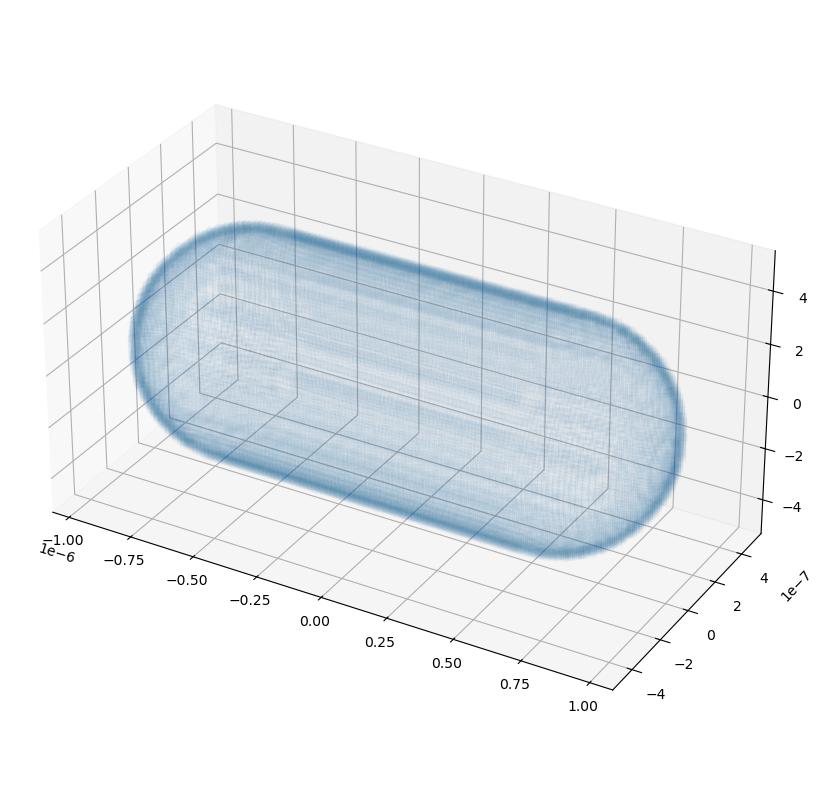

In [68]:
d = DesignTool()
d.get_blanket_space([128, 64, 64], spacing=16e-9)
d.add_ecoli_rod(l=2e-6, r=0.4e-6, barrier_type=1, offsety=0)#, offsety=1.6e-7)
d.set_border_wall()
%matplotlib inline
d.draw3D(exclude_type=[0])


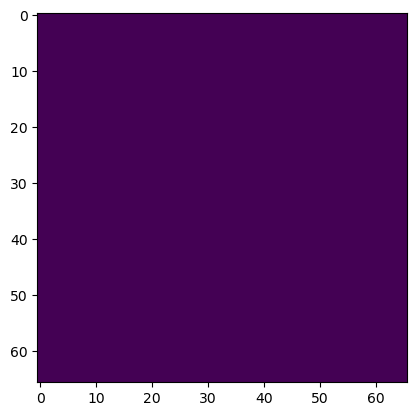

In [54]:
label = ndimage.label(1-d.barrier_type>0)
plt.imshow(label[0][1])

Sides are [128  64  64] with spacing of 1.6e-08 m (3 dimensions).
Overall system sizes are [2.048e-06 1.024e-06 1.024e-06] m
Voxel [64 32 32] has a coordinate of [0.00000000e+00 1.05879118e-22 1.05879118e-22]
Voxel [126, 32, 32] has a coordinate of [9.92000000e-07 1.05879118e-22 1.05879118e-22]
Voxel [2, 32, 32] has a coordinate of [-9.92000000e-07  1.05879118e-22  1.05879118e-22]
(130, 66, 66)


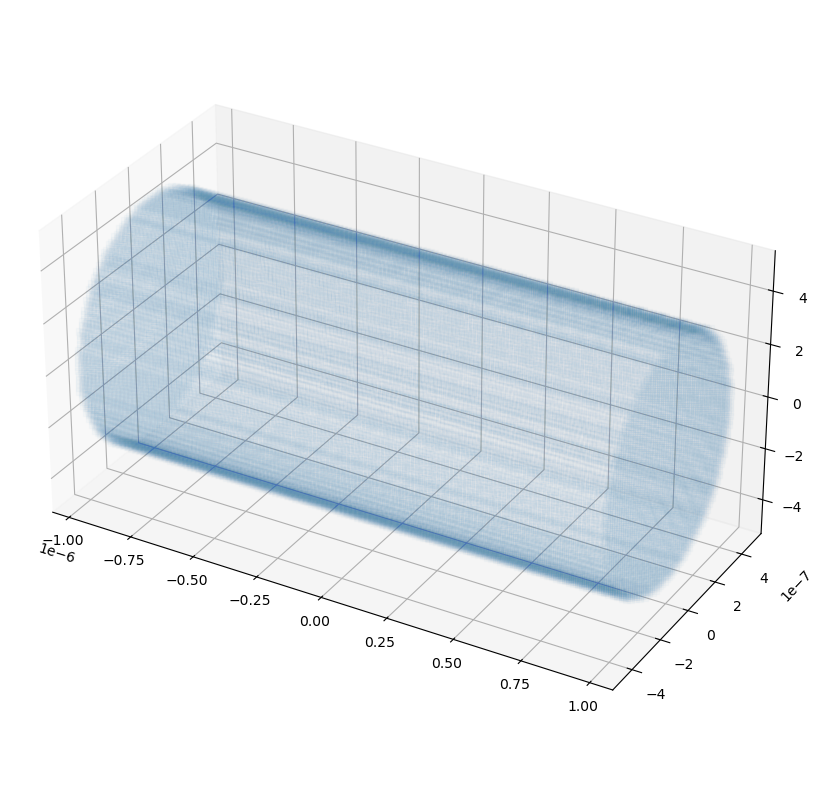

In [70]:
c = DesignTool()
c.get_blanket_space([128, 64, 64], spacing=16e-9)
c.add_rod(l=2e-6, r=0.45e-6, barrier_type=1, offsety=0)#, offsety=1.6e-7)

c.set_border_wall()
%matplotlib inline
c.draw3D(exclude_type=[0])


In [41]:
c = DesignTool()
c.get_blanket_space([64, 128], spacing=16e-9)
c.add_circle(0.45e-6, barrier_type=1, offsety=4.5e-7)#, offsety=1.6e-7)

c.set_border_wall()
c.draw2D(exclude_type=None)

Sides are [ 64 128] with spacing of 1.6e-08 m (2 dimensions).
Overall system sizes are [1.024e-06 2.048e-06] m
Voxel [32 92] has a coordinate of [1.05879118e-22 4.48000000e-07]
Determined factor for a separating boundary as 2.1
{0, 1, -1}
[-1  0  1]


Sides are [ 64  80 128] with spacing of 1.6e-08 m (3 dimensions).
Overall system sizes are [1.024e-06 1.280e-06 2.048e-06] m
Voxel [32 40 36] has a coordinate of [ 1.05879118e-22  0.00000000e+00 -4.48000000e-07]


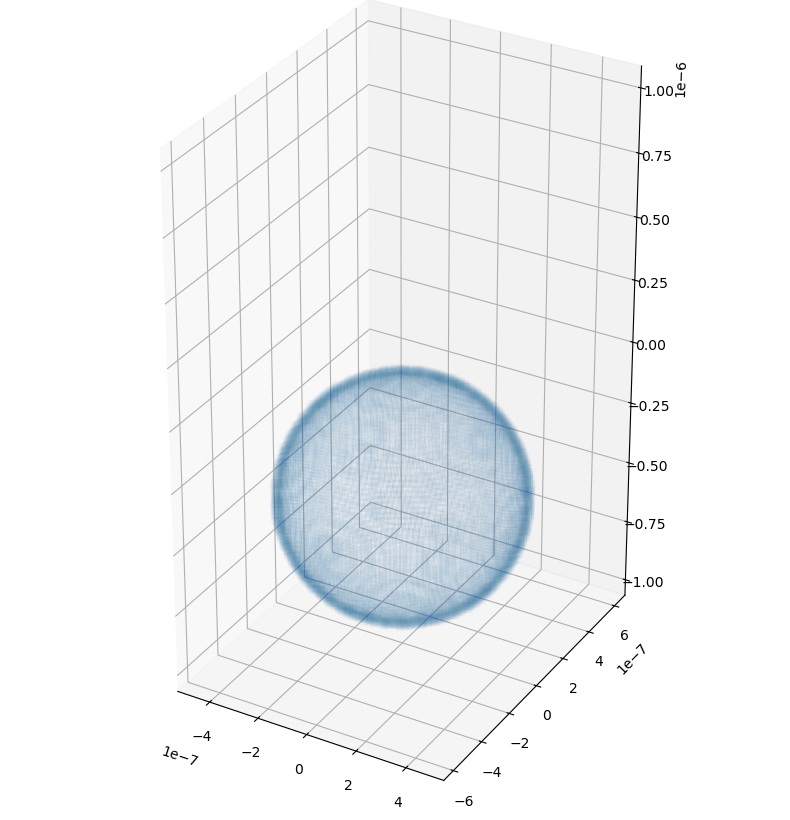

In [71]:
c = DesignTool()
c.get_blanket_space([64, 80, 128], spacing=16e-9)
c.add_circle(0.45e-6, barrier_type=1, offsetz=-4.5e-7)#, offsety=1.6e-7)

c.set_border_wall()
c.draw3D(exclude_type=[0])

Sides are [ 55 150] with spacing of 1.6e-08 m (2 dimensions).
Overall system sizes are [8.8e-07 2.4e-06] m
[26 85]
2 50 23 147
{0, 3, -1}
[-1  3]


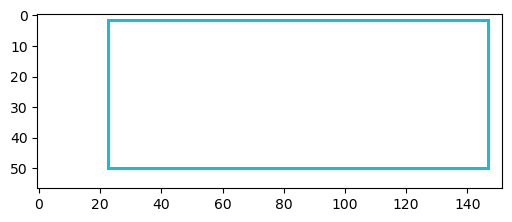

In [72]:
b = DesignTool()
b.get_blanket_space([55, 150], spacing=16e-9)
b.add_box(y=2e-6, x=0.8e-6, barrier_type=3, offsety=1.6e-7, offsetx=-4e-8)
b.set_border_wall()
b.draw2D(exclude_type=[0])

Sides are [128  64  64] with spacing of 1.6e-08 m (3 dimensions).
Overall system sizes are [2.048e-06 1.024e-06 1.024e-06] m
[67 32 32]


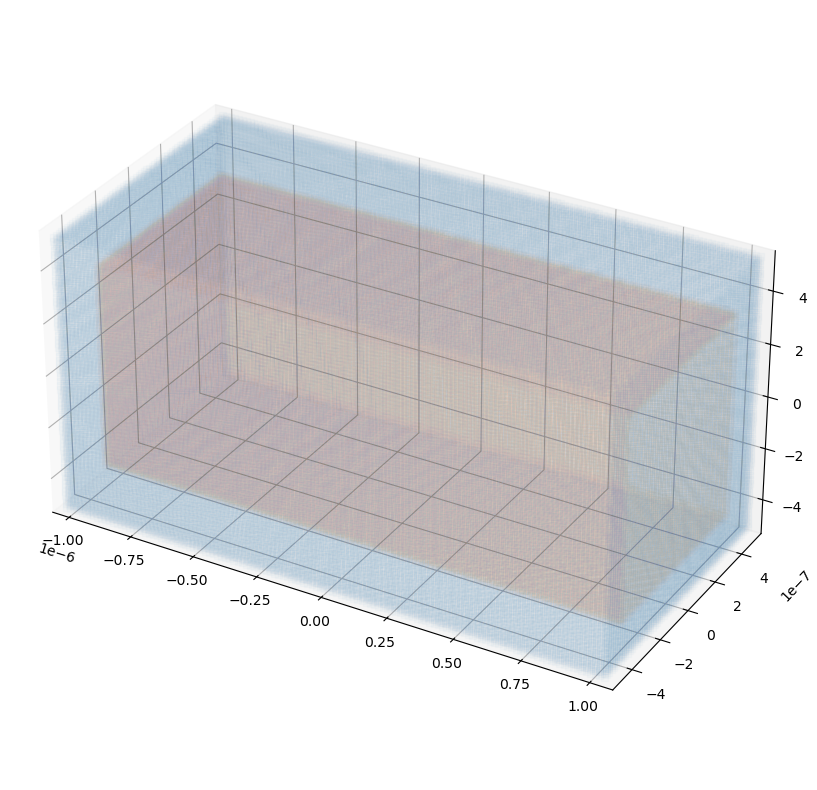

In [73]:
a = DesignTool()
a.get_blanket_space([128, 64, 64], spacing=16e-9)
a.add_box(x=2e-6, y=0.8e-6, z=0.8e-6, barrier_type=3, offsetx=0.48e-7, offsety=-0e-7)
a.set_border_wall()
a.draw3D(exclude_type=None)